# Imports

In [200]:
import os
import numpy as np
import pandas as pd
from unidecode import unidecode
from matplotlib import pyplot as plt
from matplotlib import gridspec as gridspec
import seaborn as sns
from google.cloud import storage
from ydata_profiling import ProfileReport
import math
import requests
import bs4

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
pd.set_option('display.max_columns', 100)

## Funções Auxiliares

In [262]:
def get_data(bucket_name:str, imobiliarias:str = ['apolar', 'cilar'],by:str = ['date','date_diff'], dates:list = [], date_diff:int = 2):
    storage_client = storage.Client()
    bucket = storage_client.get_bucket(bucket_name)

    files_on_bucket = [i.name for i in bucket.list_blobs()]
    files = pd.DataFrame(files_on_bucket, columns=['name'])
    files['date'] = pd.to_datetime(files['name'].apply(lambda f: f.split(' - ')[0]))
    files['imobiliaria'] = files['name'].apply(lambda f: f.split(' - ')[-1].replace('.csv',''))

    match by:
        case 'date':
            files = files.loc[files['date'].isin(dates)]
            files = files.loc[files['imobiliaria'].isin(imobiliarias)]
        case 'date_diff':
            dates = files['date'].sort_values(ascending=False).drop_duplicates().reset_index(drop=True)[:date_diff].tolist()
            files = files.loc[files['date'].isin(dates)]
            files = files.loc[files['imobiliaria'].isin(imobiliarias)]
    
    df_full = pd.DataFrame()

    for file_name in files['name'].tolist():
        try:
            df_aux = pd.read_csv(f'gs://{bucket_name}/{file_name}')
            df_full = pd.concat([df_full, df_aux], axis = 0)
        except:
            pass

    df_full = df_full.reset_index(drop=True)

    return df_full

def barplot(title:str, group:str, agg:str, agg_name:str, data:pd.DataFrame, agg_func:str, subplot:plt.subplot = None, grid:list = None, title_font_size:int =10, figure= plt.figure, figsize=(10,5),label=True, sort: bool = True):
    
    # group data
    aux = data[[group,agg]].groupby(group).agg(agg_func).reset_index().rename(columns={agg:agg_name})

    if sort:
        aux = aux.sort_values(agg_name, ascending=False)
        
    # plot
    if subplot:
        subplot(grid)
    else:
        figure(figsize=figsize)

    # plot configs
    plt.title(title, fontsize=title_font_size)
    plt.xticks(rotation = 45)

    # figure
    g = sns.barplot(x = group, y = agg_name, data = aux)

    if label:
        for i in g.containers:
            g.bar_label(i, color = 'white',label_type='center')
    else:
        pass

def histplot(title:str, col:str, data:pd.DataFrame, figsize=(10,5), label=True):

    plt.figure(figsize=figsize)
    plt.title(title)
    g = sns.histplot(x = col,  data = data)
    plt.xticks(rotation = 45)
    if label:
        for i in g.containers:
            g.bar_label(i, color = 'white',label_type='center')
    else:
        pass

def get_infos_curitiba():

    ## Request site
    response = requests.get('https://pt.wikipedia.org/wiki/Lista_de_bairros_de_Curitiba')

    ## beautiful soup object
    soup = bs4.BeautifulSoup(response.content, 'html.parser')

    # tabelas da wikipedia
    infos_tabela = soup.findAll('table', {'class','wikitable'})

    bairros_info_list = []

    ## para cada tabela
    for tabela in infos_tabela:

        # colunas
        columns = [i.text.replace('\n','') for i in tabela.findAll('th')]

        # valores da tabela
        regiao = ' '.join([i.text.replace('\xa0','').replace('\n','') for i in tabela.findAll('td')][0].replace('Bairros oficiais de Curitiba - Regional ','').split(' ')[:-1])
        table_values = [i.text.replace('\xa0','').replace('\n','') for i in tabela.findAll('td')][1::]
        table_values_list = [] 
        for i in range(0,len(table_values),7): 
            table_values_list.append(table_values[i:i+7])

        # preenchenco dicionário
        for b in table_values_list:

            bairros_info_dict = {}
            bairros_info_dict['Região'] = regiao
            bairros_info_dict['Bairro'] = b[0]
            bairros_info_dict['Área (km²)'] = b[1].replace(',','.')
            bairros_info_dict['Homens'] = b[2].replace(',','.')
            bairros_info_dict['Mulheres'] = b[3].replace(',','.')
            bairros_info_dict['Total'] = b[4].replace(',','.')
            bairros_info_dict['Domicilios particulares'] = b[5].replace(',','.')
            bairros_info_dict['Rendimento mensal médio porresponsáveis dos domicílios (R$)'] = b[6].replace(',','.')

            bairros_info_list.append(bairros_info_dict)
    
    return pd.DataFrame(bairros_info_list)

def busca_e_preenche_nulos(data, column, string_search):

    if isinstance(string_search, list):
        for s in string_search:
            data.loc[data[column] == 0, column] = np.nan
            data.loc[data[column].isna(), column] = data.loc[data[column].isna(), 'descricao'].apply(lambda x: 0 if isinstance(x,float) else 
                                                                                                            1 if s in unidecode(x.lower()) else 0)
    elif isinstance(string_search,str):
        data.loc[data[column] == 0, column] = np.nan
        data.loc[data[column].isna(), column] = data.loc[data[column].isna(), 'descricao'].apply(lambda x: 0 if isinstance(x,float) else 
                                                                                                            1 if string_search in unidecode(x.lower()) else 0)
    else:
        raise("Atributo 'string_search' deve ser uma lista ou uma string" )
    
    return data

def vagas_garagem(descricao):
    # Procura por padrões do tipo 'Garagem: [quantidade]' na descrição
    padrao = r'Garagem: (\d+)'
    resultado = re.search(padrao, descricao)

    if resultado:
        # Se encontrou, retorna a quantidade de vagas
        return int(resultado.group(1))
    else:
        # Se não encontrou ou não há informação sobre vagas, retorna 0
        return 0

# Carregar Dados

In [202]:
df_full = get_data(
    bucket_name='busca-apartamentos-trusted',
    by='date',
    dates=['2024-03-17']
)

In [203]:
df_full

,site,titulo,link,data_coleta,endereco,atributos,descricao,bairro,cidade,aluguel,condominio,seguro_incendio,iptu,area,quartos,suites,banheiros,vagas_garagem,mobiliado,piscina,academia,sacada,churrasqueira,salao_de_festas,caracteristicas_imovel,detalhes_condominio,mais_detalhes_imovel
0,Apolar,Apartamento Residencial para Locação no Ecovil...,https://www.apolar.com.br/alugar/curitiba/ecov...,2024-03-17,"Rua Dep. Heitor Alencar Furtado, 3180, Ecovill...","330 m², 2 vagas, 4 quartos",Apartamento com 4 quartos no Bairro Ecoville I...,Ecoville,Curitiba,10500.0,1549.67,87.58,21.37,330.0,4.0,NaN,NaN,2.0,Não,Não,Não,Não,Não,Não,NaN,NaN,NaN
1,Apolar,Apartamento Residencial para Locação no Mercês...,https://www.apolar.com.br/alugar/curitiba/merc...,2024-03-17,"Avenida Cândido Hartmann, 330, Mercês - Curitiba","163 m², 2 banheiros, 2 vagas, 2 quartos, 1 sui...",Apartamento com 2 quartos no Bairro Mercês Imó...,Merces,Curitiba,7000.0,1690.58,53.19,341.74,163.0,2.0,1.0,2.0,2.0,Não,Não,Sim,Não,Sim,Não,NaN,NaN,NaN
2,Apolar,Apartamento Residencial para Locação no Bigorr...,https://www.apolar.com.br/alugar/curitiba/bigo...,2024-03-17,"Rua Coronel Joaquim Ignácio Taborda Ribas, 864...","103 m², 2 banheiros, 2 vagas, 3 quartos, 1 sui...",Apartamento com 3 quartos no Bairro Bigorrilho...,Bigorrilho,Curitiba,4400.0,915.67,39.14,NaN,103.0,3.0,1.0,2.0,2.0,Não,Não,Sim,Sim,Não,Sim,NaN,NaN,NaN
3,Apolar,Apartamento Residencial para Locação no Bigorr...,https://www.apolar.com.br/alugar/curitiba/bigo...,2024-03-17,"Alameda Júlia Da Costa, 2242, Bigorrilho - Cur...","118 m², 2 banheiros, 1 vaga, 3 quartos, 1 suite",Apartamento com 3 quartos no Bairro Bigorrilho...,Bigorrilho,Curitiba,4200.0,688.11,41.48,197.11,118.0,3.0,1.0,2.0,1.0,Não,Não,Sim,Sim,Sim,Sim,NaN,NaN,NaN
4,Apolar,Apartamento Residencial para Locação no Portão...,https://www.apolar.com.br/alugar/curitiba/port...,2024-03-17,"Avenida República Argentina, 2751, Portão - Cu...","90 m², 1 banheiro, 1 vaga, 2 quartos",Apartamento com 2 quartos no Bairro Portão Imó...,Portao,Curitiba,4200.0,653.60,35.63,NaN,90.0,2.0,NaN,1.0,1.0,Sim,Não,Sim,Sim,Sim,Sim,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
806,Cilar,Apartamento no 4º andar com 2 quartos,https://cilar.com.br/alugar/apartamento-no-4-a...,2024-03-17,"R HOWELL LEWIS FRY, 341 - CACHOEIRA - Curitiba",NaN,NaN,Cachoeira,Curitiba,850.0,320.00,0.00,42.25,52.0,2.0,0.0,1.0,1.0,Não,Não,Não,Não,Não,Sim,Belo apartamento situado em uma área estratégi...,"Salão de festas, Playground, Portaria 24h, Gar...","Andar: 4, Aptos por andar: 4, Área privativa: ..."
807,Cilar,Apartamento com 2 quartos,https://cilar.com.br/alugar/apartamento-com-2-...,2024-03-17,"R Atilio Borio, 139 - Cristo Rei - Curitiba",NaN,NaN,Cristo rei,Curitiba,850.0,465.00,0.00,52.99,52.0,2.0,0.0,1.0,0.0,Não,Não,Não,Não,Não,Não,Imediações: RODOFERROVIARIA Detalhes: 02 DOR...,Elevador,"Ano de construção: 33 Ano(s), Área privativa: ..."
808,Cilar,Apartamento com 3 quartos,https://cilar.com.br/alugar/apartamento-com-3-...,2024-03-17,"R LUIZ RONALDO CANALLI, 3294 - CAMPO COMPRIDO ...",NaN,NaN,Campo comprido,Curitiba,800.0,520.00,0.00,20.65,55.0,3.0,0.0,1.0,1.0,Não,Não,Não,Não,Não,Não,Pontos de Referências: Próximo ao Supermercado...,"Playground, Portaria 24h, Garagem Coberta","Aptos por andar: 4, Área privativa: 49.64, Áre..."
809,Cilar,Apartamento no 5º andar com 1 quarto,https://cilar.com.br/alugar/apartamento-no-5-a...,2024-03-17,"Rua Cruz Machado, 311 - Centro - Curitiba",NaN,NaN,Centro,Curitiba,800.0,382.00,0.00,51.19,48.0,1.0,0.0,1.0,0.0,Não,Não,Não,Não,Não,Não,Apartamento para locação 1 quarto no Centro. ...,NaN,"Andar: 5, Área privativa: 48, Área total: 48, ..."


# Análise Descritiva dos Dados

- Quantidade de Dados
- Quantidade de Dados Faltantes
- Tipo de Variáveis
- Estatística Descritiva

In [204]:
df = df_full.copy()

## Dimensão dos Dados

In [205]:
print(f'Total de Linhas {df.shape[0]}')
print(f'Total de Colunas {df.shape[1]}')

Total de Linhas 811
Total de Colunas 27


## Tratando NAs

In [206]:
df.isna().sum()

site                        0
titulo                      1
link                        0
data_coleta                 0
endereco                    1
atributos                 487
descricao                 487
bairro                      2
cidade                      1
aluguel                     1
condominio                 57
seguro_incendio             0
iptu                      177
area                        1
quartos                     1
suites                    279
banheiros                 103
vagas_garagem              62
mobiliado                   1
piscina                     1
academia                    1
sacada                      1
churrasqueira               1
salao_de_festas             1
caracteristicas_imovel    326
detalhes_condominio       385
mais_detalhes_imovel      325
dtype: int64

### Removendo NAs

In [207]:
## Removendo anuncios com falha na requisição
df = df.dropna(subset=['titulo'])
df = df.loc[df['titulo'] != 'ref.']

## Removendo anuncios em descrição ou caracterísitca dos imóveis
df = df.loc[((~ df['descricao'].isna()) & (df['site'] == 'Apolar')) | ((~ df['caracteristicas_imovel'].isna()) & (df['site'] == 'Cilar'))]
# df = df.loc[(~ df['catacteristicas_imovel'].isna()) & (df['site'] == 'Cilar')]


In [208]:
df.isna().sum()

site                        0
titulo                      0
link                        0
data_coleta                 0
endereco                    0
atributos                 485
descricao                 485
bairro                      1
cidade                      0
aluguel                     0
condominio                 56
seguro_incendio             0
iptu                      175
area                        0
quartos                     0
suites                    278
banheiros                 102
vagas_garagem              62
mobiliado                   0
piscina                     0
academia                    0
sacada                      0
churrasqueira               0
salao_de_festas             0
caracteristicas_imovel    324
detalhes_condominio       384
mais_detalhes_imovel      324
dtype: int64

### Preechendo NAs

In [209]:
import re
def extrai_valores_string(string,substring):

    # Padronizar a expressão regular para encontrar a área total
    padrao = f'{substring} (\d+)'

    # Encontrar a área total usando regex
    area_total = re.search(padrao, string)

    if area_total:
        # Extrair o valor numérico da área total
        valor_area = area_total.group(1)
        
        # Remover vírgulas e converter para float
        valor_area = int(valor_area.replace(',', '.'))
        
    else:
        valor_area = 0
    
    return valor_area

In [210]:
df.loc[df['site'] == 'Cilar', 'atributos'] = df.loc[df['site'] == 'Cilar', 'detalhes_condominio']
df.loc[df['site'] == 'Cilar', 'descricao'] = df.loc[df['site'] == 'Cilar', 'caracteristicas_imovel']
df.loc[df['site'] == 'Cilar', 'ficha_tecnica'] = df.loc[df['site'] == 'Cilar', 'mais_detalhes_imovel']

df = busca_e_preenche_nulos(df, 'quartos', 'dormitorio')
df = busca_e_preenche_nulos(df, 'suites', 'suite')
df = busca_e_preenche_nulos(df, 'banheiros', ['banheiro','bwc','wc','bec','lavabo'])

# Quando não há valor do condomínio, entende-se que o valor está incluso no aluguel
df.loc[:,'condominio'] = df['condominio'].fillna(0)

# Quando não há valor do iptu, entende-se que o valor está incluso no aluguel
df.loc[:,'iptu'] = df['iptu'].fillna(0)

# # Quando vazio, significa que não há vagas
df.loc[:,'vagas_garagem'] = df['vagas_garagem'].fillna(0)

In [211]:
    
df.loc[(df['vagas_garagem'] == 0) & (df['site'] == 'Apolar' ), 'vagas_garagem'] = df.loc[(df['vagas_garagem'] == 0) & (df['site'] == 'Apolar' ), 'descricao'].apply(lambda x: vagas_garagem(x))

In [212]:
df.loc[(df['sacada'].isna()) & (df['site'] == 'Cilar' ), 'sacada'] = df.loc[df['sacada'].isna(), 'ficha_tecnica'].apply(lambda x: 'Não' if extrai_valores_string(x.replace(':',''), 'Sacadas') == 0 else 'Sim')
df.loc[(df['salao_de_festas'].isna()) & (df['site'] == 'Cilar' ), 'salao_de_festas'] = df.loc[df['salao_de_festas'].isna(), 'ficha_tecnica'].apply(lambda x: 'Não' if extrai_valores_string(x.replace(':',''), 'Salão de festas') == 0 else 'Sim')
df.loc[(df['piscina'].isna()) & (df['site'] == 'Cilar' ), 'piscina'] = df.loc[df['piscina'].isna(), 'ficha_tecnica'].apply(lambda x: 'Não' if extrai_valores_string(x.replace(':',''), 'Piscina') == 0 else 'Sim')
df.loc[(df['mobiliado'].isna()) & (df['site'] == 'Cilar' ), 'mobiliado'] = df.loc[df['mobiliado'].isna(), 'ficha_tecnica'].apply(lambda x: 'Não' if extrai_valores_string(x.replace(':',''), 'Mobiliado') == 0 else 'Sim')
df.loc[(df['academia'].isna()) & (df['site'] == 'Cilar' ), 'academia'] = df.loc[df['academia'].isna(), 'ficha_tecnica'].apply(lambda x: 'Não' if extrai_valores_string(x.replace(':',''), 'Fitness') == 0 else 'Sim')
df.loc[(df['churrasqueira'].isna()) & (df['site'] == 'Cilar' ), 'churrasqueira'] = df.loc[df['churrasqueira'].isna(), 'ficha_tecnica'].apply(lambda x: 'Não' if extrai_valores_string(x.replace(':','').replace(' coletiva','').replace(' priv',''), 'Churrasqueira') == 0 else 'Sim')
df.loc[(df['vagas_garagem']==0) & (df['site'] == 'Cilar' ), 'vagas_garagem'] = df.loc[df['vagas_garagem'] == 0, 'ficha_tecnica'].apply(lambda x: 0 if pd.isnull(x) else extrai_valores_string(x, 'Vagas de garagem:'))

## Tipos de Variáveis

In [213]:
df['data_coleta']   = pd.to_datetime(df['data_coleta'])
df['quartos']       = df['quartos'].astype('int64')
df['suites']        = df['suites'].astype('int64')
df['banheiros']     = df['banheiros'].astype('int64')
df['vagas_garagem'] = df['vagas_garagem'].astype('int64')

In [214]:
df.dtypes

site                              object
titulo                            object
link                              object
data_coleta               datetime64[ns]
endereco                          object
atributos                         object
descricao                         object
bairro                            object
cidade                            object
aluguel                          float64
condominio                       float64
seguro_incendio                  float64
iptu                             float64
area                             float64
quartos                            int64
suites                             int64
banheiros                          int64
vagas_garagem                      int64
mobiliado                         object
piscina                           object
academia                          object
sacada                            object
churrasqueira                     object
salao_de_festas                   object
caracteristicas_

## Estatística Descritiva

In [215]:
num_attributes = df.select_dtypes(include=['int64','float64'])
cat_attributes = df.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,aluguel,560.0,13000.00,12440.00,2140.615575,1750.00,1405.556657,3.462301,17.346818
1,condominio,0.0,3189.70,3189.70,581.363572,500.00,390.839587,1.989864,7.421284
2,seguro_incendio,0.0,87.58,87.58,12.615624,0.00,16.131832,0.751226,-0.625256
3,iptu,0.0,874.00,874.00,85.650087,57.25,104.755898,3.091122,14.038491
4,area,0.0,787.00,787.00,90.378245,73.00,65.497150,3.136958,19.484248
5,quartos,0.0,4.00,4.00,2.063041,2.00,0.840702,0.168109,-0.797672
6,suites,0.0,3.00,3.00,0.412855,0.00,0.558236,1.116362,1.211410
7,banheiros,0.0,4.00,4.00,1.168109,1.00,0.478380,2.407050,7.174288
8,vagas_garagem,0.0,4.00,4.00,0.887515,1.00,0.637482,0.559743,1.557272


In [217]:
cat_attributes = cat_attributes.drop(columns=['titulo','link','endereco','caracteristicas_imovel','detalhes_condominio', 'atributos','descricao','ficha_tecnica','mais_detalhes_imovel'])
cat_attributes

,site,bairro,cidade,mobiliado,piscina,academia,sacada,churrasqueira,salao_de_festas
0,Apolar,Ecoville,Curitiba,Não,Não,Não,Não,Não,Não
1,Apolar,Merces,Curitiba,Não,Não,Sim,Não,Sim,Não
2,Apolar,Bigorrilho,Curitiba,Não,Não,Sim,Sim,Não,Sim
3,Apolar,Bigorrilho,Curitiba,Não,Não,Sim,Sim,Sim,Sim
4,Apolar,Portao,Curitiba,Sim,Não,Sim,Sim,Sim,Sim
...,...,...,...,...,...,...,...,...,...
806,Cilar,Cachoeira,Curitiba,Não,Não,Não,Não,Não,Sim
807,Cilar,Cristo rei,Curitiba,Não,Não,Não,Não,Não,Não
808,Cilar,Campo comprido,Curitiba,Não,Não,Não,Não,Não,Não
809,Cilar,Centro,Curitiba,Não,Não,Não,Não,Não,Não


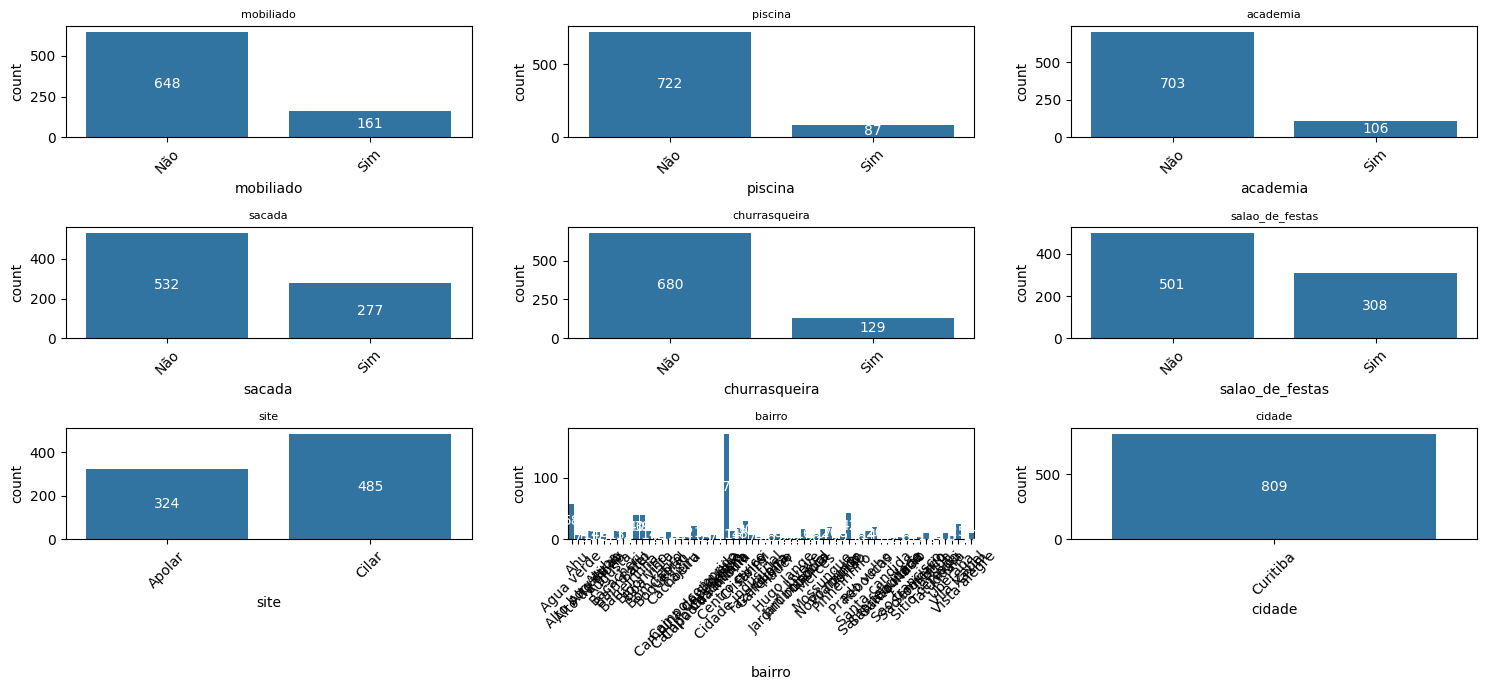

In [229]:
grid = gridspec.GridSpec(3,4)
plt.figure(figsize=(20,7))

for i in range(cat_attributes.shape[1]):
    q, mod = divmod(i,3)
    col = cat_attributes.columns.tolist()[i]
    f = plt.subplot
    barplot(title= f'{col}',
            title_font_size=8,
            group=col,
            agg='link', 
            agg_name = 'count',
            agg_func = 'count',
            data = df,
            subplot = f,
            grid = grid[q-1, mod],
            sort=False)
plt.tight_layout()

In [230]:
df['bairro'] = df['bairro'].str.strip()

ajustes = {
    'Ecoville':'Mossungue',
    'Champagnat':'Bigorrilho',
    'Alto da rua xv': 'Alto da xv',
    'Novo mundo ': 'Novo mundo'
}

df['bairro'] = df['bairro'].replace(ajustes)

# Filtrando Variáveis

## Removendo Erros do dataset

- Apartamentos com área igual a zero. 
    - Inputar dados com knnimputer?
- Apartamentos sem quartos,
    - imóveis comerciais?

In [231]:
df = df.loc[~((df['quartos'] == 0) & (df['suites'] == 0))]
df = df.loc[df['area'] > 5]
df = df.reset_index(drop=True)

## Removendo colunas

In [233]:
df = df.drop(columns=['caracteristicas_imovel','detalhes_condominio', 'atributos','descricao','ficha_tecnica','mais_detalhes_imovel'])

# Feature Engineering

### Info dos bairros

In [234]:
# infos_curitiba = get_infos_curitiba()
# infos_curitiba['Bairro'] = infos_curitiba['Bairro'].apply(lambda x: unidecode(x).capitalize().strip())
# infos_curitiba[[ 'Área (km²)', 'Homens', 'Mulheres', 'Total', 'Domicilios particulares', 'Rendimento mensal médio porresponsáveis dos domicílios (R$)']] = infos_curitiba[[ 'Área (km²)', 'Homens', 'Mulheres', 'Total', 'Domicilios particulares', 'Rendimento mensal médio porresponsáveis dos domicílios (R$)']].astype('float64')
# df = pd.merge(df, infos_curitiba, left_on = 'bairro', right_on = 'Bairro', how = 'left')

### Valor Total

In [235]:
df.loc[:,'valor_total'] = df['aluguel'] + df['condominio'] + df['seguro_incendio'] + df['iptu']

### Preço m²

In [236]:
df['preco_metro_2'] = df[['area','valor_total']].apply(lambda x: np.nan if x['area'] < 2 else x['valor_total']/x['area'], axis = 1).astype('float')

# Análise Exploratória de Dados

Entendendo a distribuição e a relação entre as variáveis

## Análise Univariada

### Variável Resposta

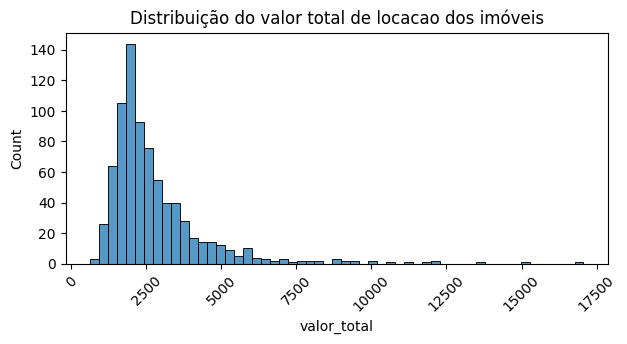

In [237]:
histplot('Distribuição do valor total de locacao dos imóveis',
         col = 'valor_total',
         data = df,
         figsize=(7,3),
         label = False)

### Variáveis Numéricas

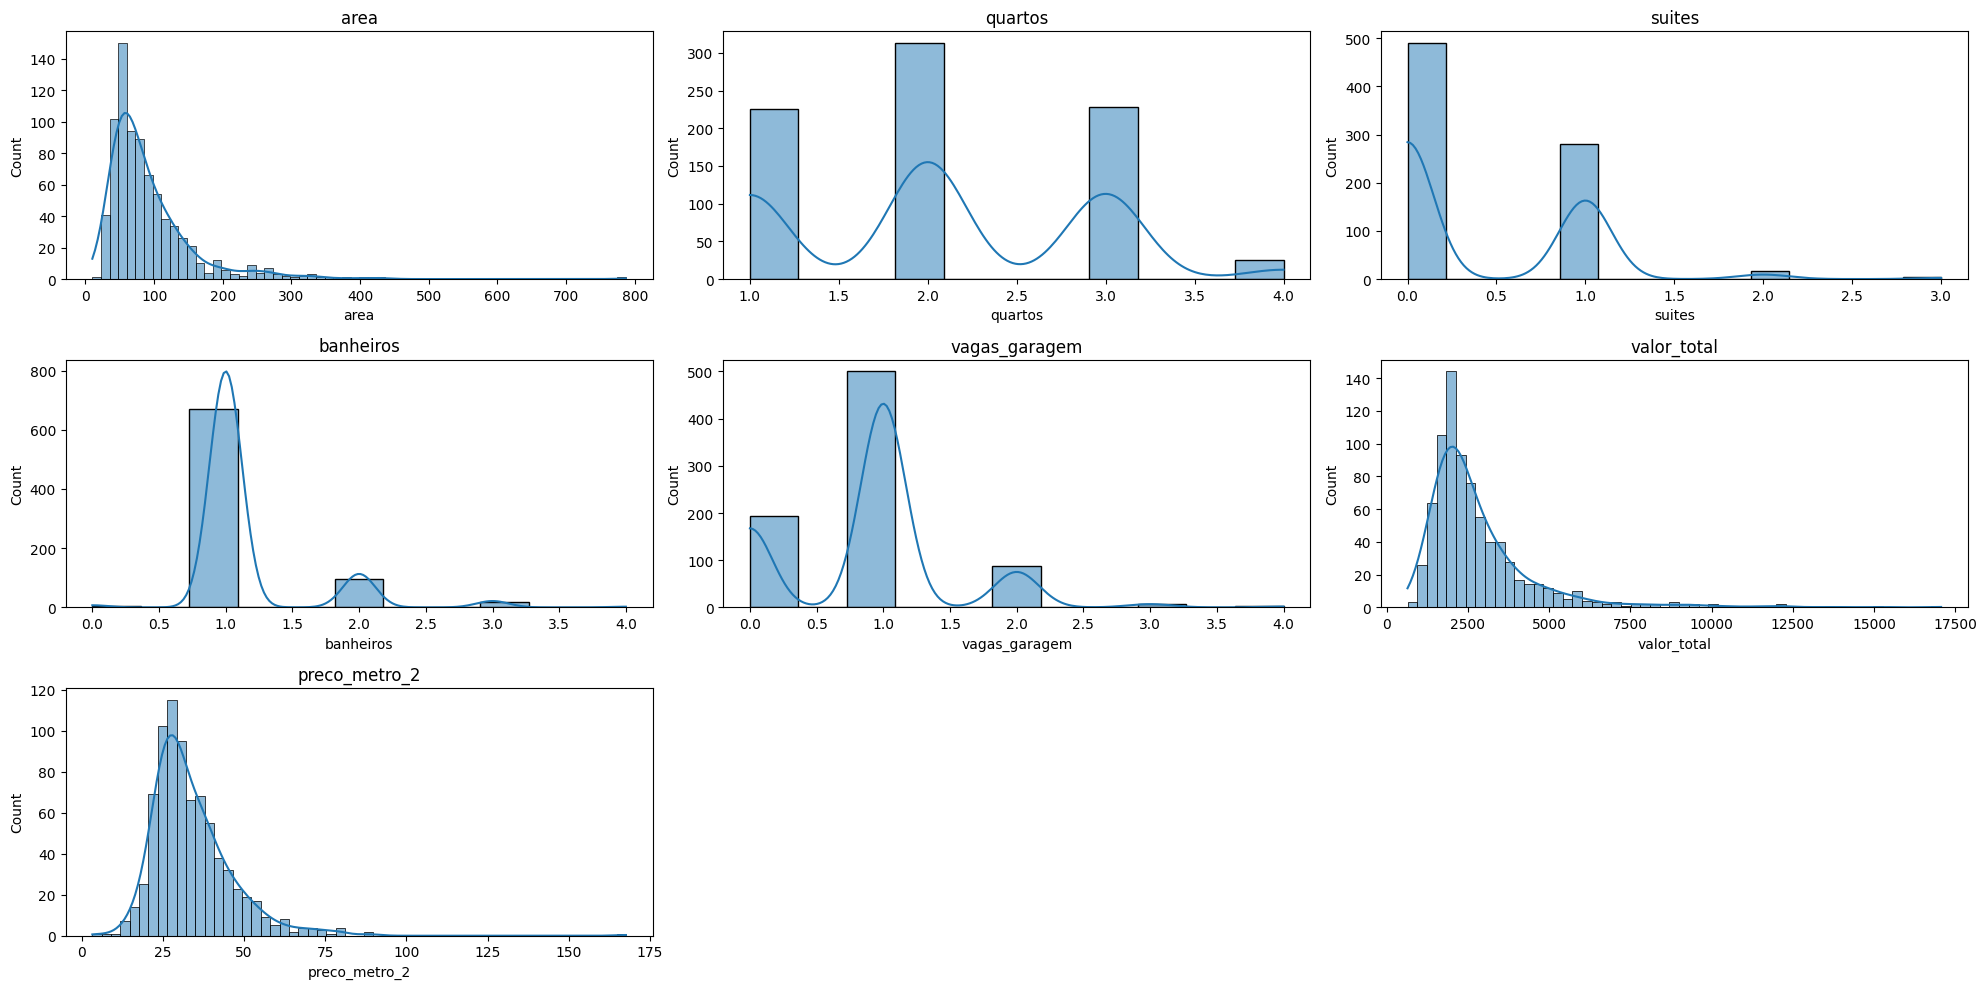

In [238]:
columns = ['area', 'quartos', 'suites', 'banheiros', 'vagas_garagem', 'valor_total', 'preco_metro_2']

rows = 3
cols = 3

grid = gridspec.GridSpec(rows,cols);
plt.figure(figsize=(20,10));
elem = 0

for i in range(rows):
    for j in range(cols):

        plt.subplot(grid[i,j]);
        plt.title(columns[i*rows+j])
        sns.histplot(df[columns[i*rows+j]], kde=True);

        elem += 1
        if elem == len(columns):
            break

plt.tight_layout()

### Variáveis Categóricas

In [239]:
cols = ['mobiliado', 'piscina','academia', 'sacada', 'churrasqueira', 'salao_de_festas']

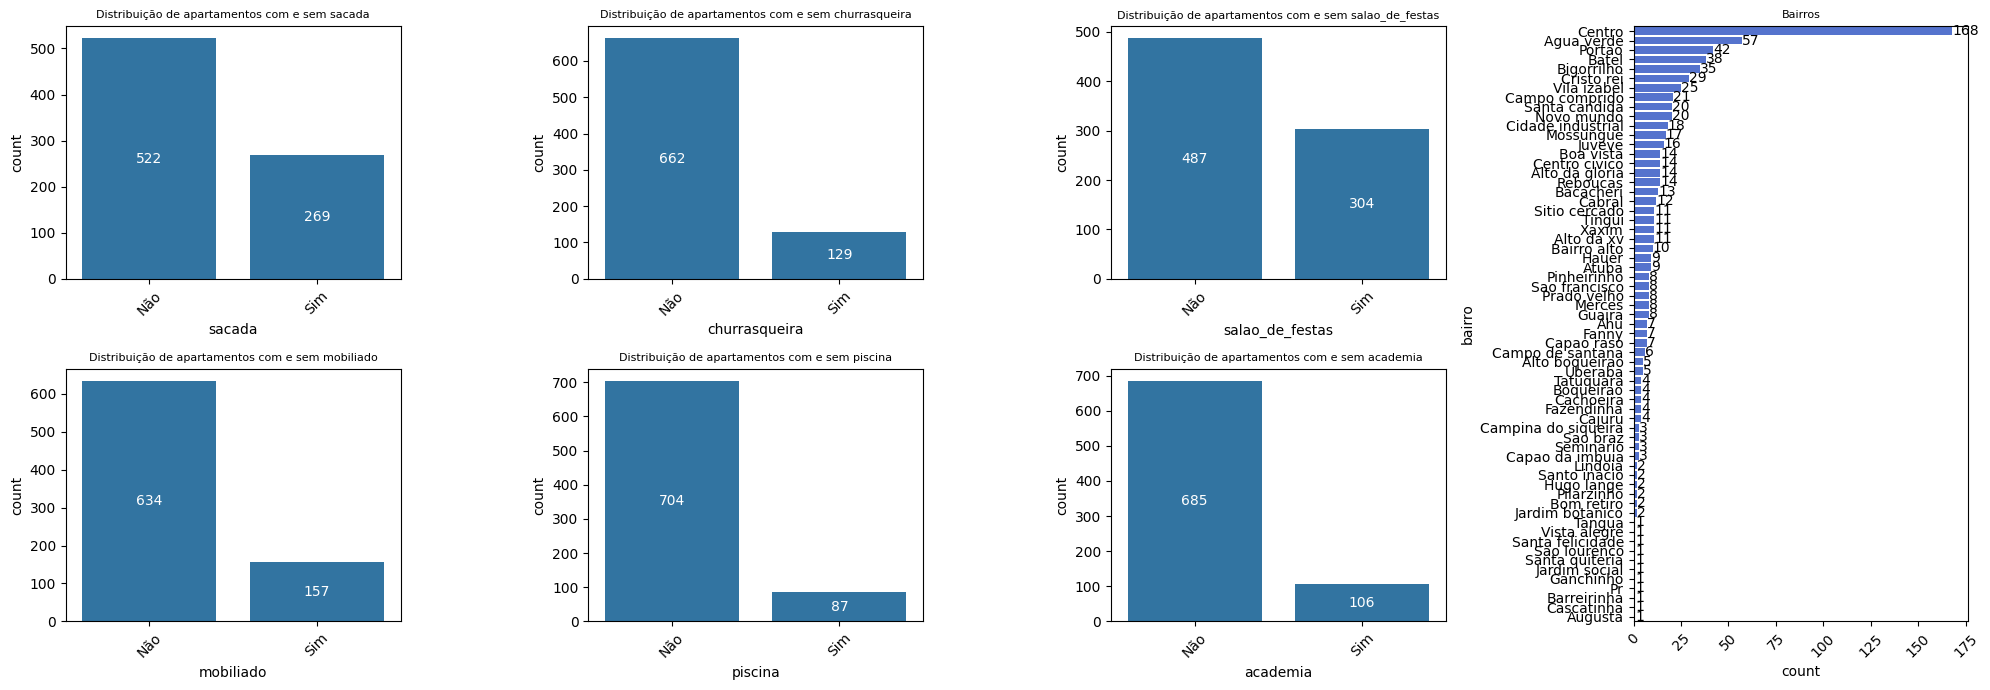

In [240]:
grid = gridspec.GridSpec(2,4)
plt.figure(figsize=(20,7))

cols = ['mobiliado', 'piscina','academia', 'sacada', 'churrasqueira', 'salao_de_festas']

for i in range(len(cols)):
    
    q, mod = divmod(i,3)

    f1 = plt.subplot
    col = cols[i]
    barplot(title=f'Distribuição de apartamentos com e sem {col}',
            title_font_size=8,
            group=col,
            agg='valor_total', 
            agg_name = 'count',
            agg_func = 'count',
            data = df,
            subplot = f1,
            grid = grid[q-1,mod],
            sort=False)

plt.subplot(grid[:,3])

aux = df[['bairro','valor_total']].groupby('bairro').agg('count').reset_index().rename(columns={'valor_total':'count'}).sort_values('count', ascending=False)

plt.title('Bairros', fontsize=8)
g = sns.barplot(x = 'count', y = 'bairro', data = aux, color='royalblue')
plt.xticks(rotation = 45)
for i in g.containers:
    g.bar_label(i, color = 'black',label_type='edge')

plt.tight_layout()

## Análise Bivariada

### Bairro

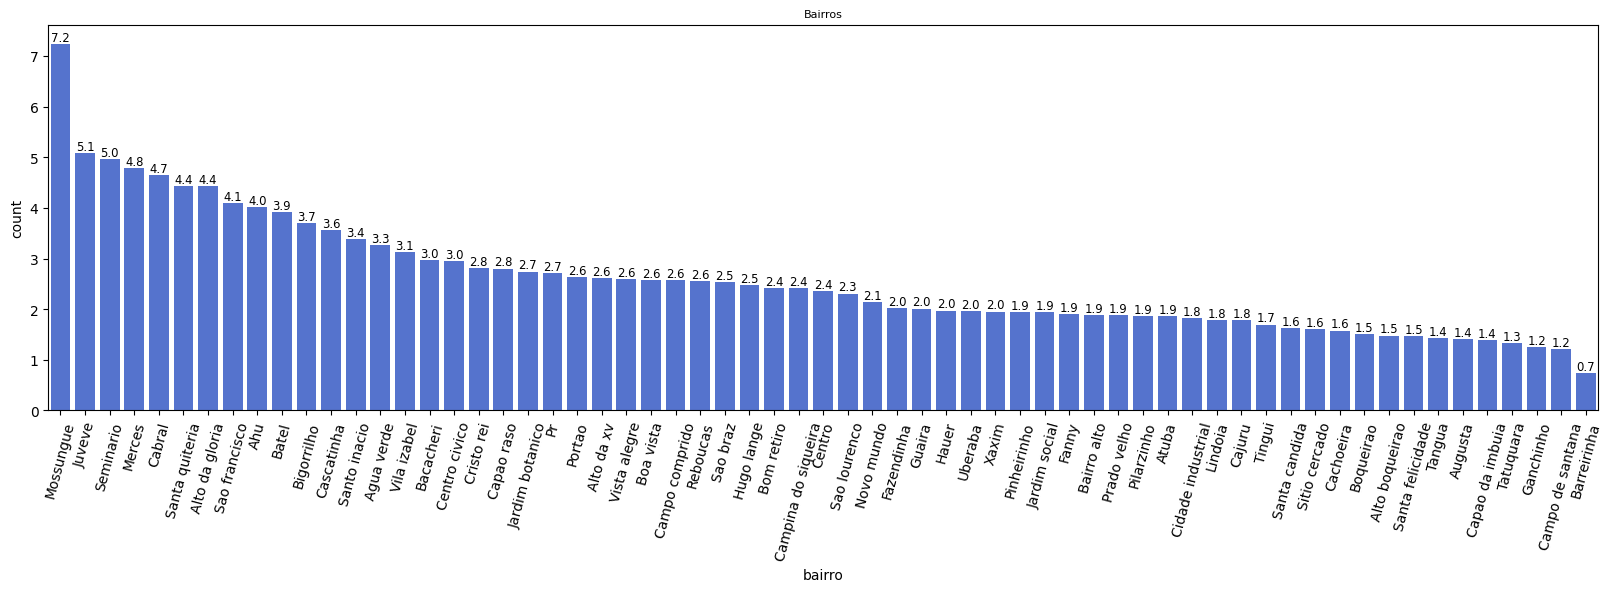

In [241]:
plt.figure(figsize=(20,5))
aux = df[['bairro','valor_total']]
aux['valor_total'] = aux['valor_total']/1000 
aux = aux[['bairro','valor_total']].groupby('bairro').agg('mean').reset_index().rename(columns={'valor_total':'count'}).sort_values('count', ascending=False)

plt.title('Bairros', fontsize=8)
g = sns.barplot(x = 'bairro', y = 'count', data = aux, color='royalblue')
plt.xticks(rotation = 75)
for i in g.containers:
    g.bar_label(i, color = 'black',label_type='edge',fontsize = 'small',fmt='%.1f')

### Area

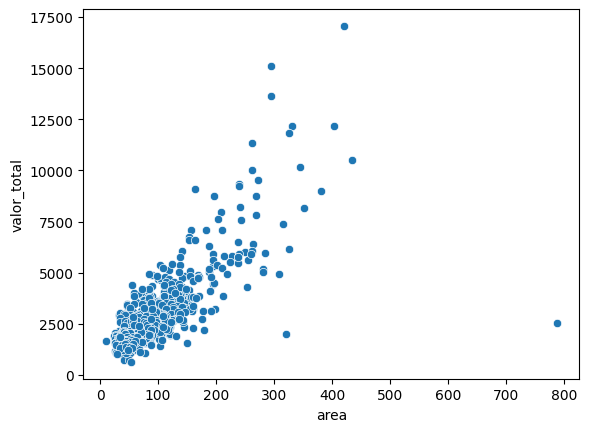

In [244]:
sns.scatterplot(x = 'area', y = 'valor_total', data = df);

### Preco m²

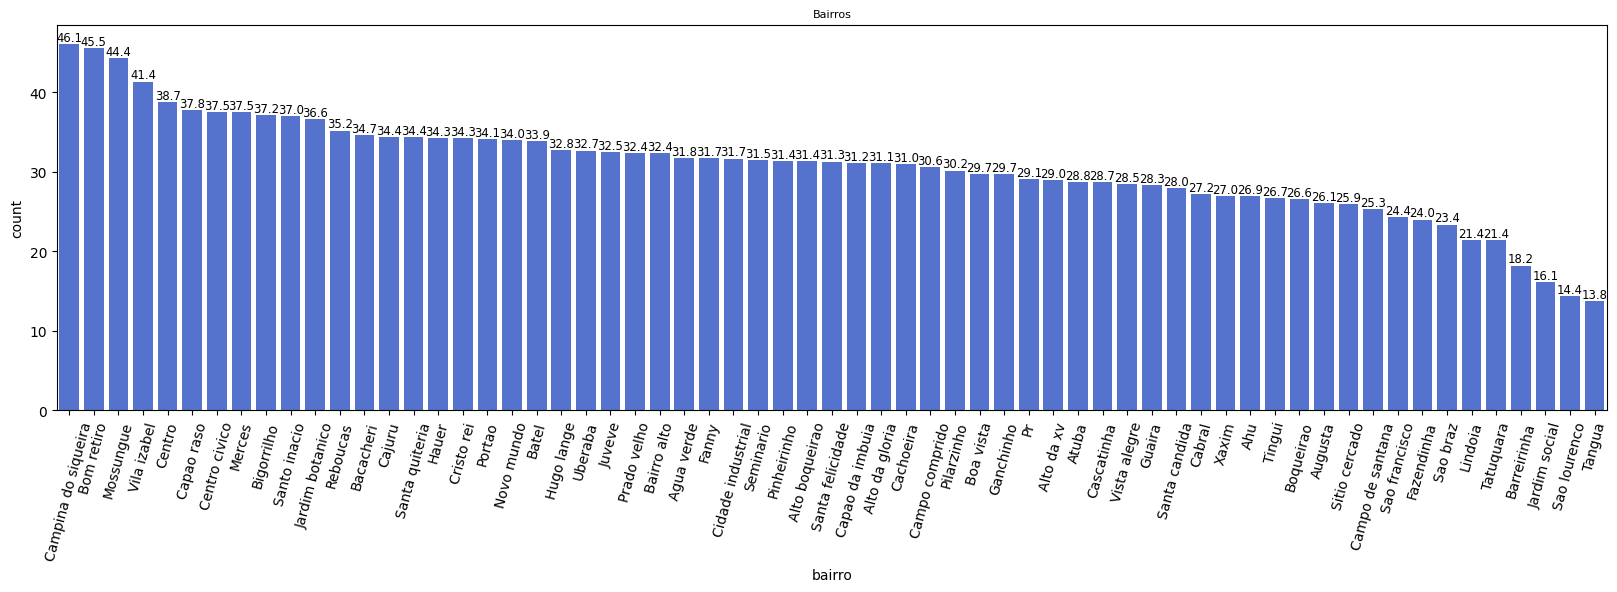

In [245]:
plt.figure(figsize=(20,5))
aux = df[['bairro','preco_metro_2']].groupby('bairro').agg('mean').reset_index().rename(columns={'preco_metro_2':'count'}).sort_values('count', ascending=False)

plt.title('Bairros', fontsize=8)
g = sns.barplot(x = 'bairro', y = 'count', data = aux, color='royalblue')
plt.xticks(rotation = 75)
for i in g.containers:
    g.bar_label(i, color = 'black',label_type='edge',fontsize = 'small',fmt='%.1f')

### Quartos

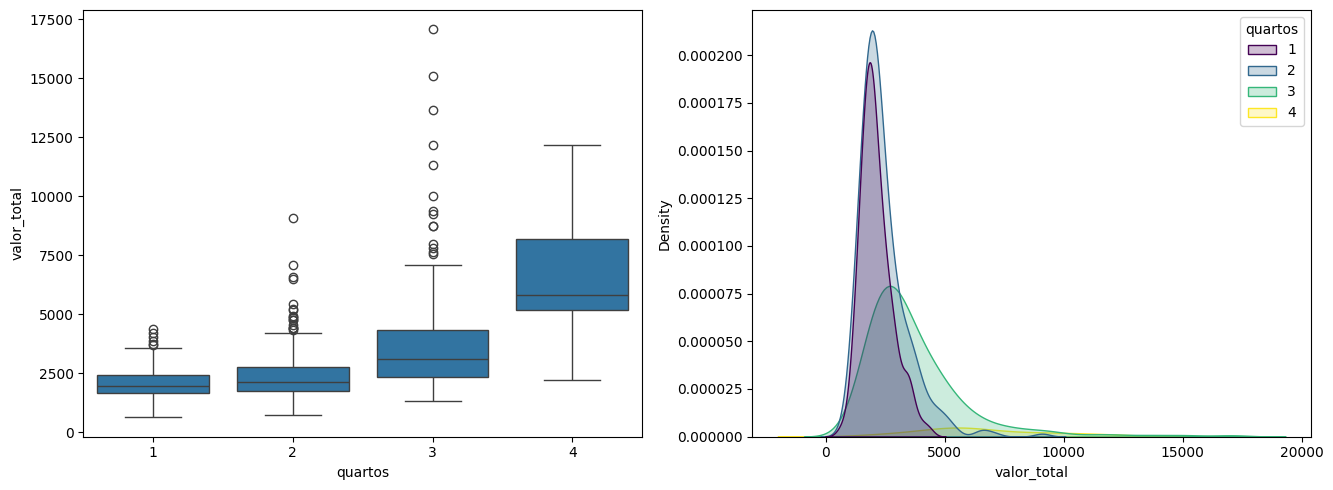

In [246]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.boxplot(x='quartos' , y='valor_total', data=df)

plt.subplot(1,3,2)
sns.kdeplot(x = 'valor_total' , hue= 'quartos', data=df, palette='viridis', fill=True)

plt.tight_layout()

### Suites

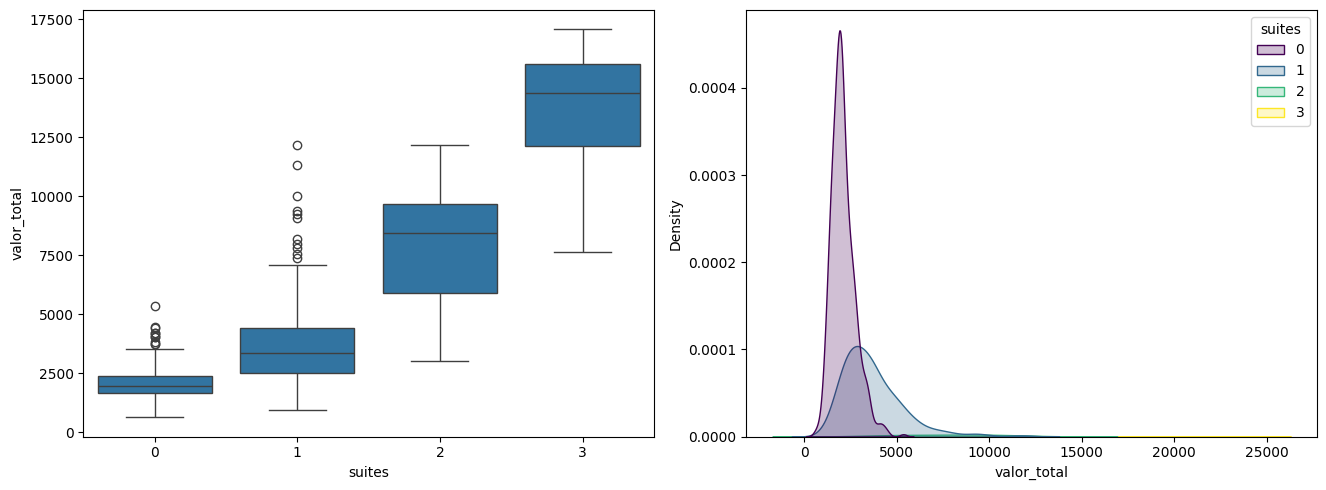

In [247]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.boxplot(x='suites' , y='valor_total', data=df)

plt.subplot(1,3,2)
sns.kdeplot(x = 'valor_total' , hue= 'suites', data=df, palette='viridis', fill=True)

plt.tight_layout()

### Banheiros

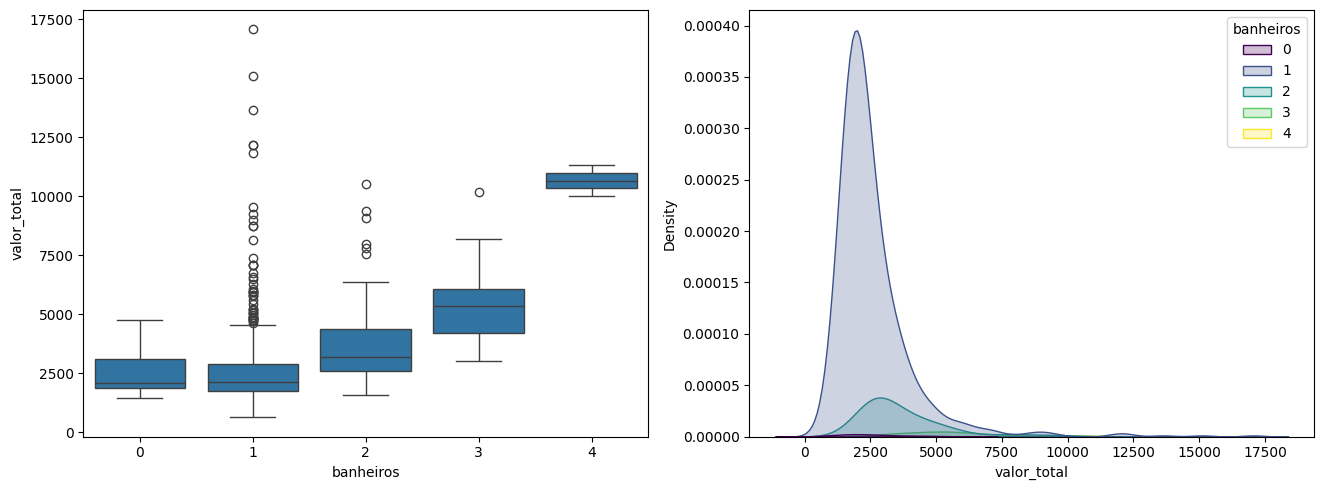

In [248]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.boxplot(x='banheiros' , y='valor_total', data=df)

plt.subplot(1,3,2)
sns.kdeplot(x = 'valor_total' , hue= 'banheiros', data=df, palette='viridis', fill=True)

plt.tight_layout()

### Vagas garagem

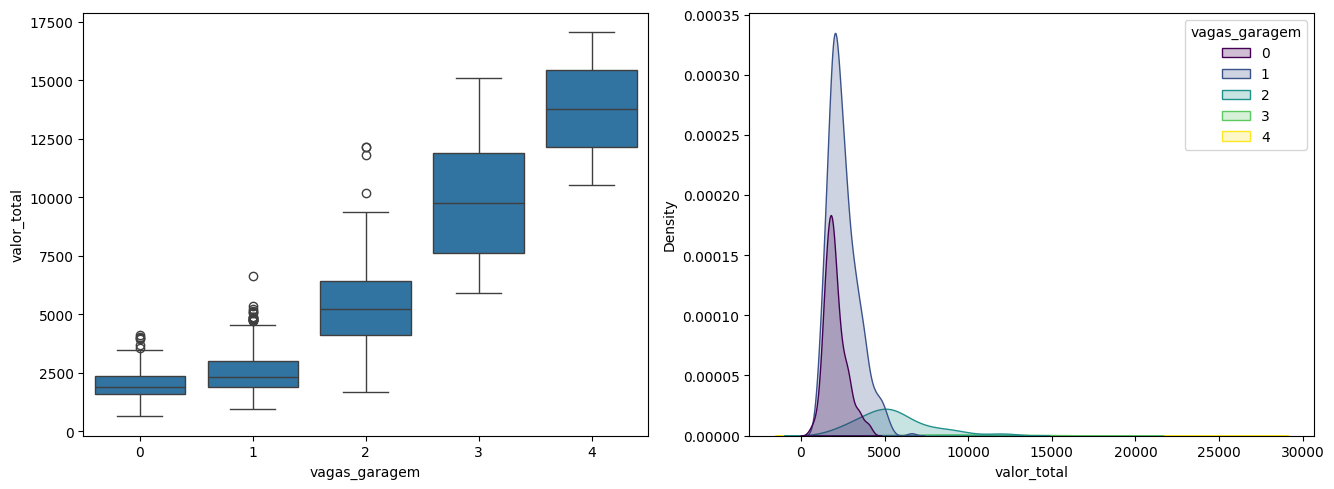

In [249]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.boxplot(x='vagas_garagem' , y='valor_total', data=df)

plt.subplot(1,3,2)
sns.kdeplot(x = 'valor_total' , hue= 'vagas_garagem', data=df, palette='viridis', fill=True)

plt.tight_layout()

### Mobiliado

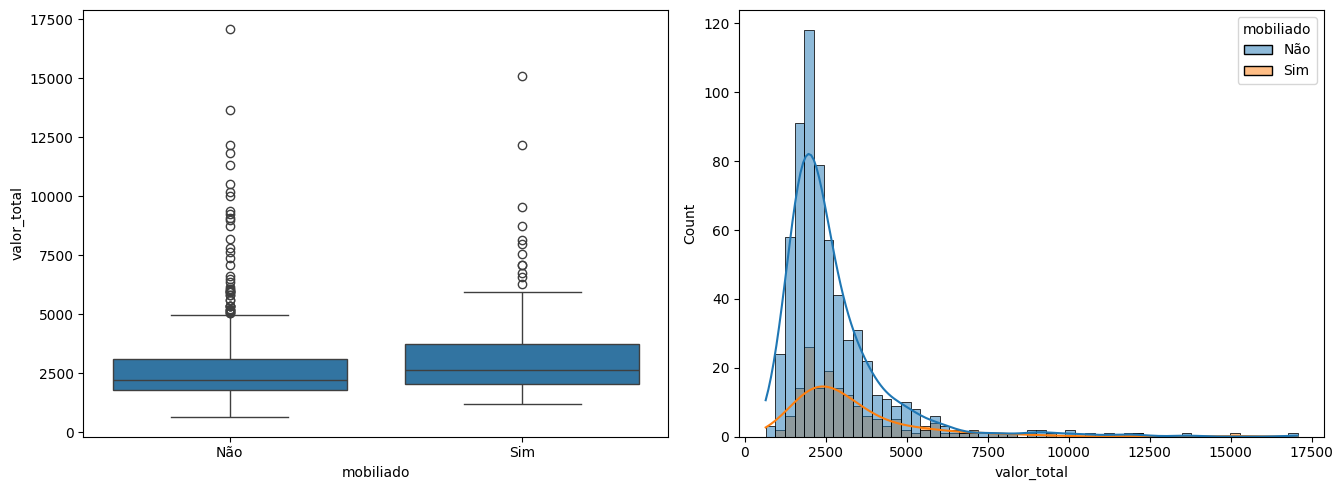

In [250]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.boxplot(x='mobiliado' , y='valor_total', data=df)

plt.subplot(1,3,2)
sns.histplot(x = 'valor_total' , hue= 'mobiliado', data=df, kde=True, hue_order=['Não','Sim'])

plt.tight_layout()

### Piscina

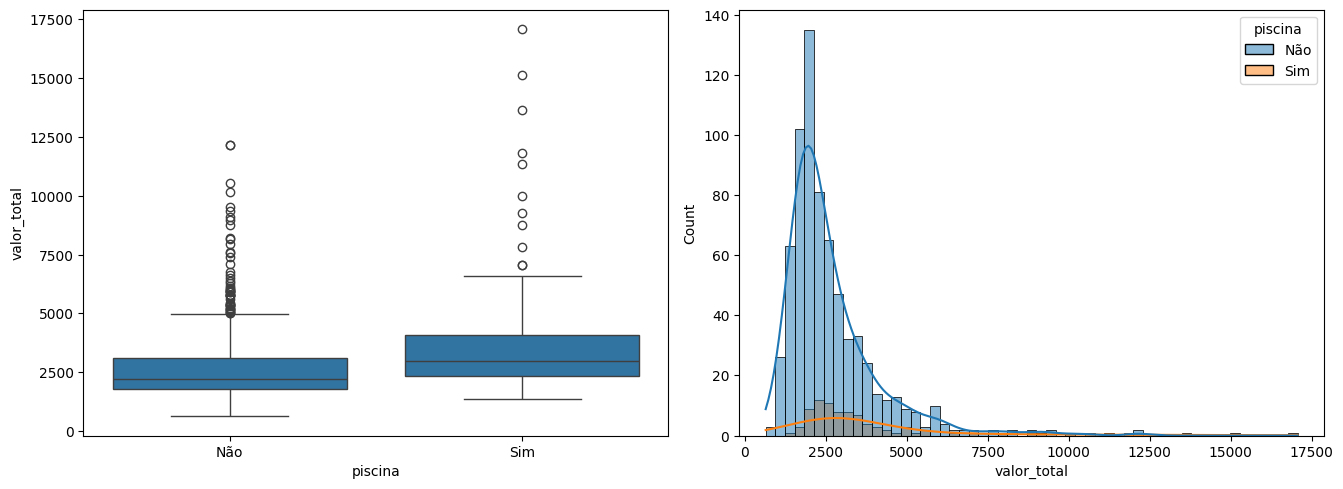

In [251]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.boxplot(x='piscina' , y='valor_total', data=df)

plt.subplot(1,3,2)
sns.histplot(x = 'valor_total' , hue= 'piscina', data=df, kde=True, hue_order=['Não','Sim'])

plt.tight_layout()

### Academia

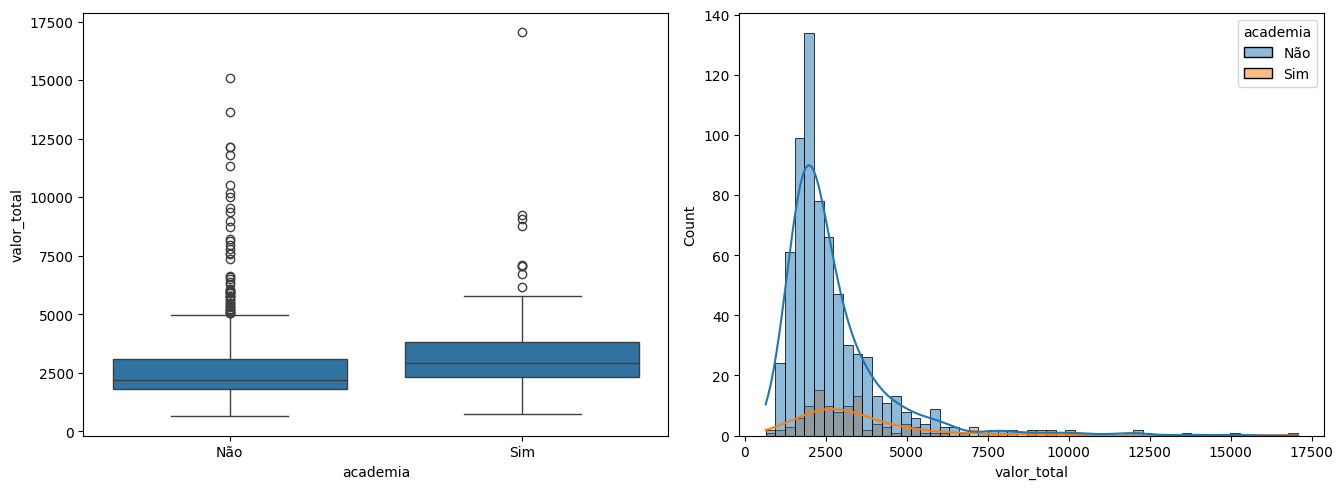

In [253]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.boxplot(x='academia' , y='valor_total', data=df)

plt.subplot(1,3,2)
sns.histplot(x = 'valor_total' , hue= 'academia', data=df, kde=True, hue_order=['Não','Sim'])

plt.tight_layout()

### Sacada

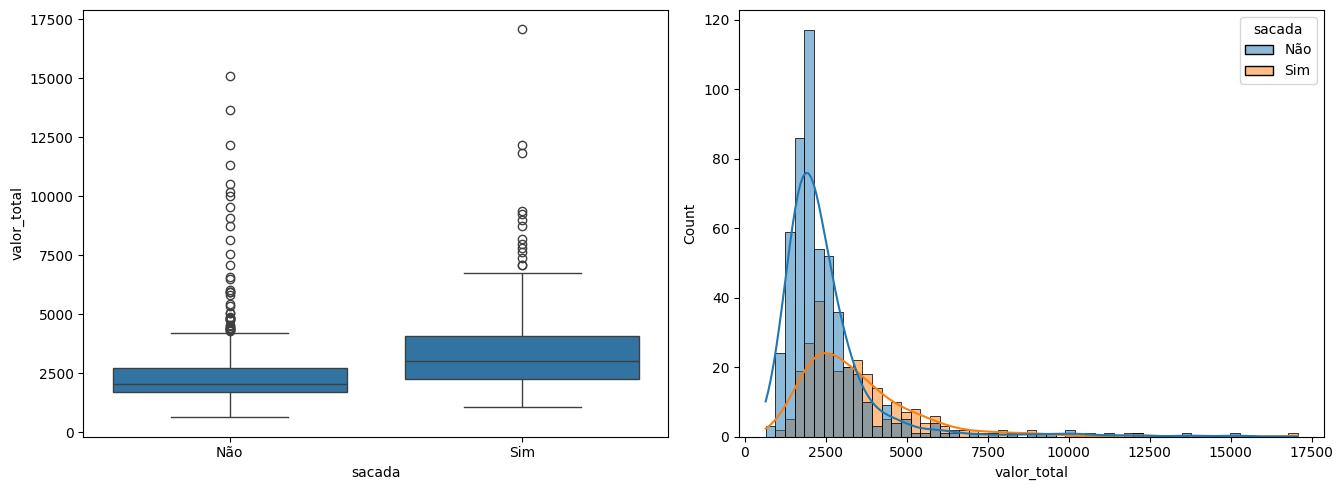

In [255]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.boxplot(x='sacada' , y='valor_total', data=df)

plt.subplot(1,3,2)
sns.histplot(x = 'valor_total' , hue= 'sacada', data=df, kde=True, hue_order=['Não','Sim'])

plt.tight_layout()

### Churrasqueira

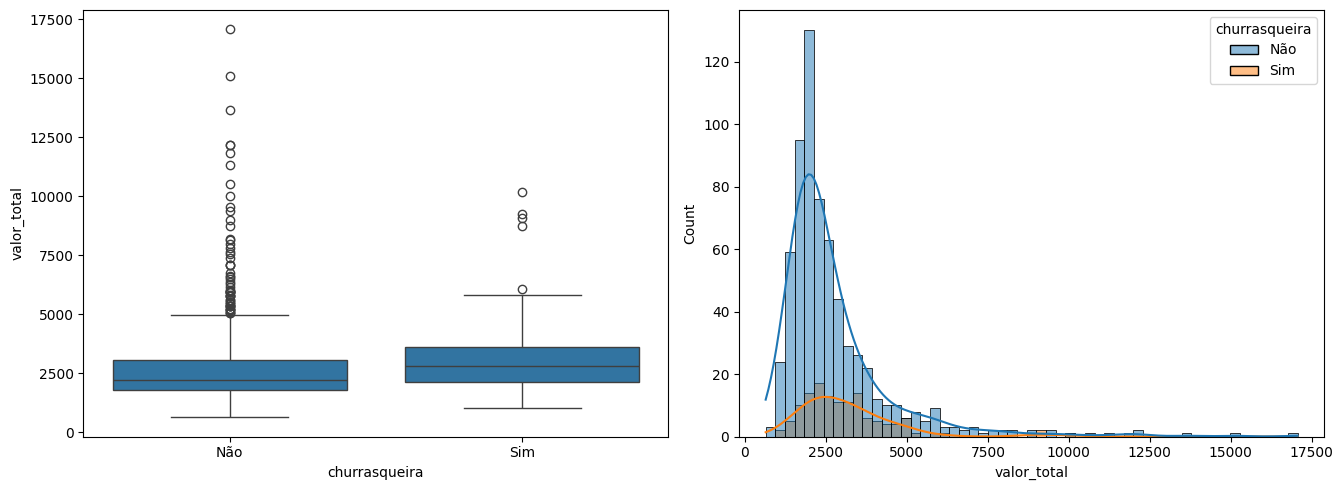

In [256]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.boxplot(x='churrasqueira' , y='valor_total', data=df)

plt.subplot(1,3,2)
sns.histplot(x = 'valor_total' , hue= 'churrasqueira', data=df, kde=True, hue_order=['Não','Sim'])

plt.tight_layout()

### Salão de festas

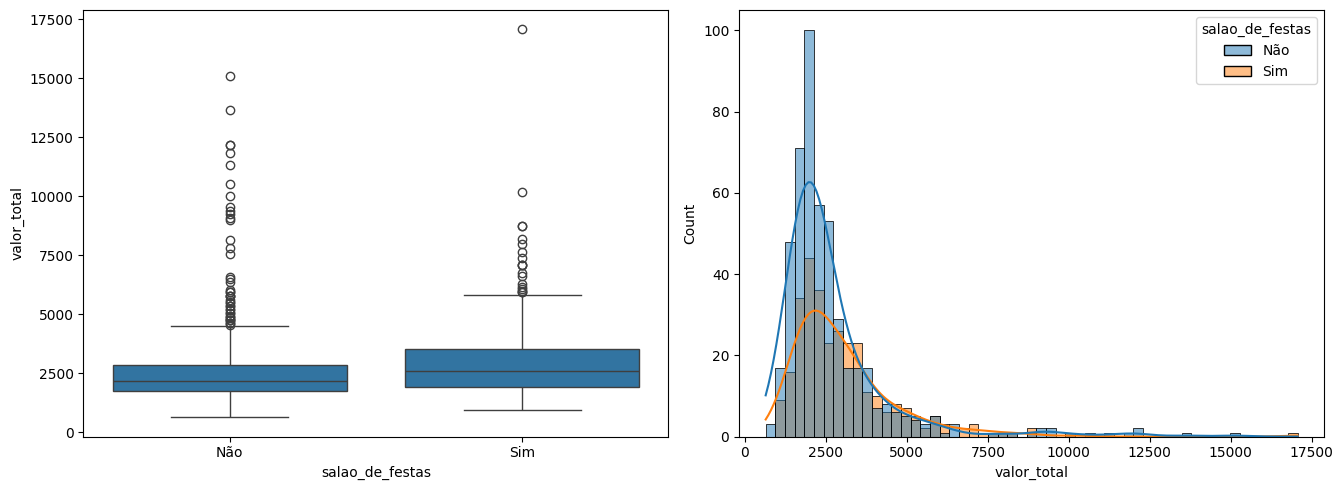

In [257]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.boxplot(x='salao_de_festas' , y='valor_total', data=df)

plt.subplot(1,3,2)
sns.histplot(x = 'valor_total' , hue= 'salao_de_festas', data=df, kde=True, hue_order=['Não','Sim'])

plt.tight_layout()

## Análise Multivariada

In [258]:
aux = df.copy()

aux['mobiliado'] = df['mobiliado'].map({'Sim':1,'Não':0})
aux['piscina'] = df['piscina'].map({'Sim':1,'Não':0})
aux['academia'] = df['academia'].map({'Sim':1,'Não':0})
aux['sacada'] = df['sacada'].map({'Sim':1,'Não':0})
aux['churrasqueira'] = df['churrasqueira'].map({'Sim':1,'Não':0})
aux['salao_de_festas'] = df['salao_de_festas'].map({'Sim':1,'Não':0})

<Axes: xlabel='area', ylabel='preco_metro_2'>

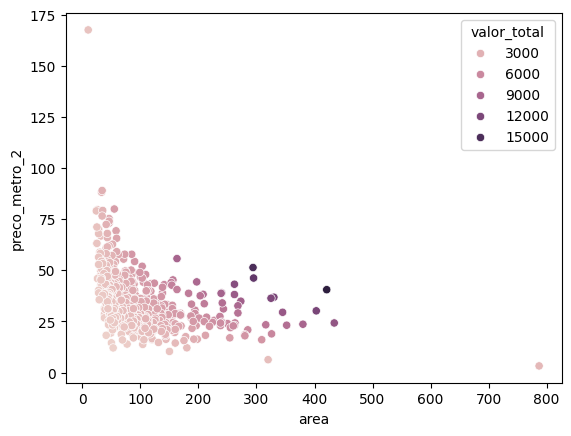

In [259]:
sns.scatterplot(x = 'area', y = 'preco_metro_2',hue='valor_total', data=df)

<Axes: xlabel='area', ylabel='preco_metro_2'>

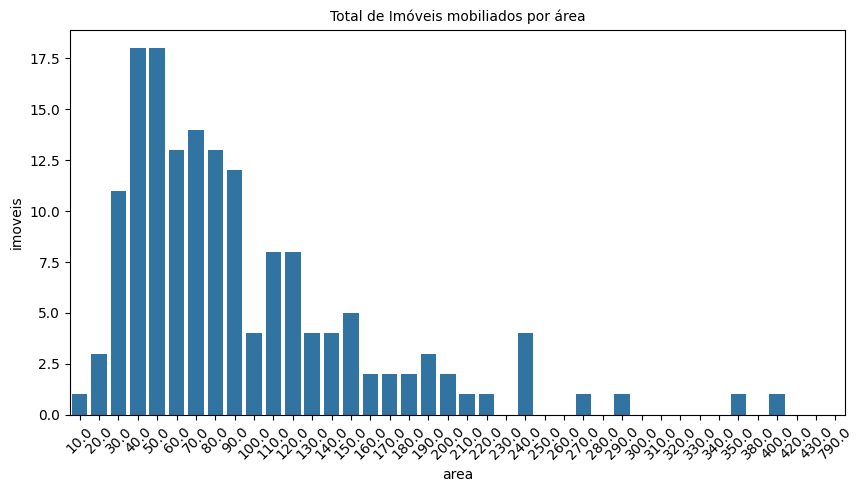

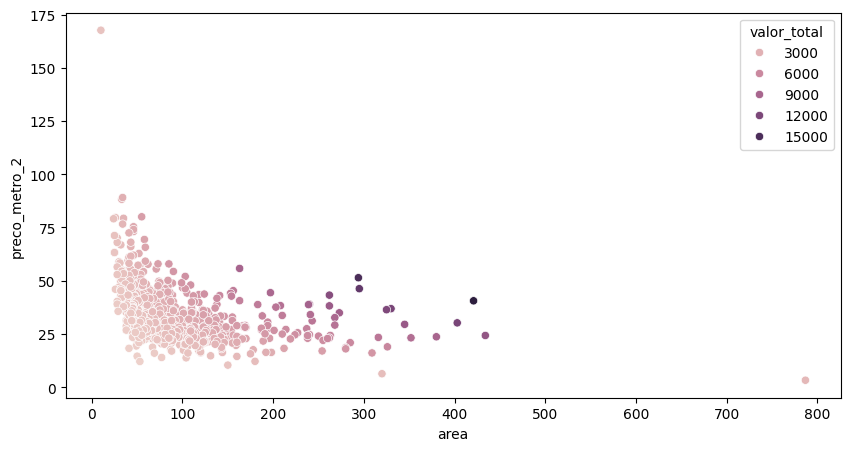

In [264]:
aux1 = df[['area','mobiliado','sacada','academia','piscina','churrasqueira','salao_de_festas','valor_total']].copy()

aux1['area'] = (round((aux1['area']/10),0)*10)

aux1['mobiliado'] = aux1['mobiliado'].map({'Sim':1,'Não':0})
aux1['piscina'] = aux1['piscina'].map({'Sim':1,'Não':0})
aux1['academia'] = aux1['academia'].map({'Sim':1,'Não':0})
aux1['sacada'] = aux1['sacada'].map({'Sim':1,'Não':0})
aux1['churrasqueira'] = aux1['churrasqueira'].map({'Sim':1,'Não':0})
aux1['salao_de_festas'] = aux1['salao_de_festas'].map({'Sim':1,'Não':0})

barplot(
    title='Total de Imóveis mobiliados por área',
    group='area',
    agg='mobiliado',
    agg_name='imoveis',
    agg_func='sum',
    data=aux1,
    sort=False,
    label=False)

plt.figure(figsize=(10,5))
sns.scatterplot(x = 'area', y = 'preco_metro_2',hue='valor_total', data=df)


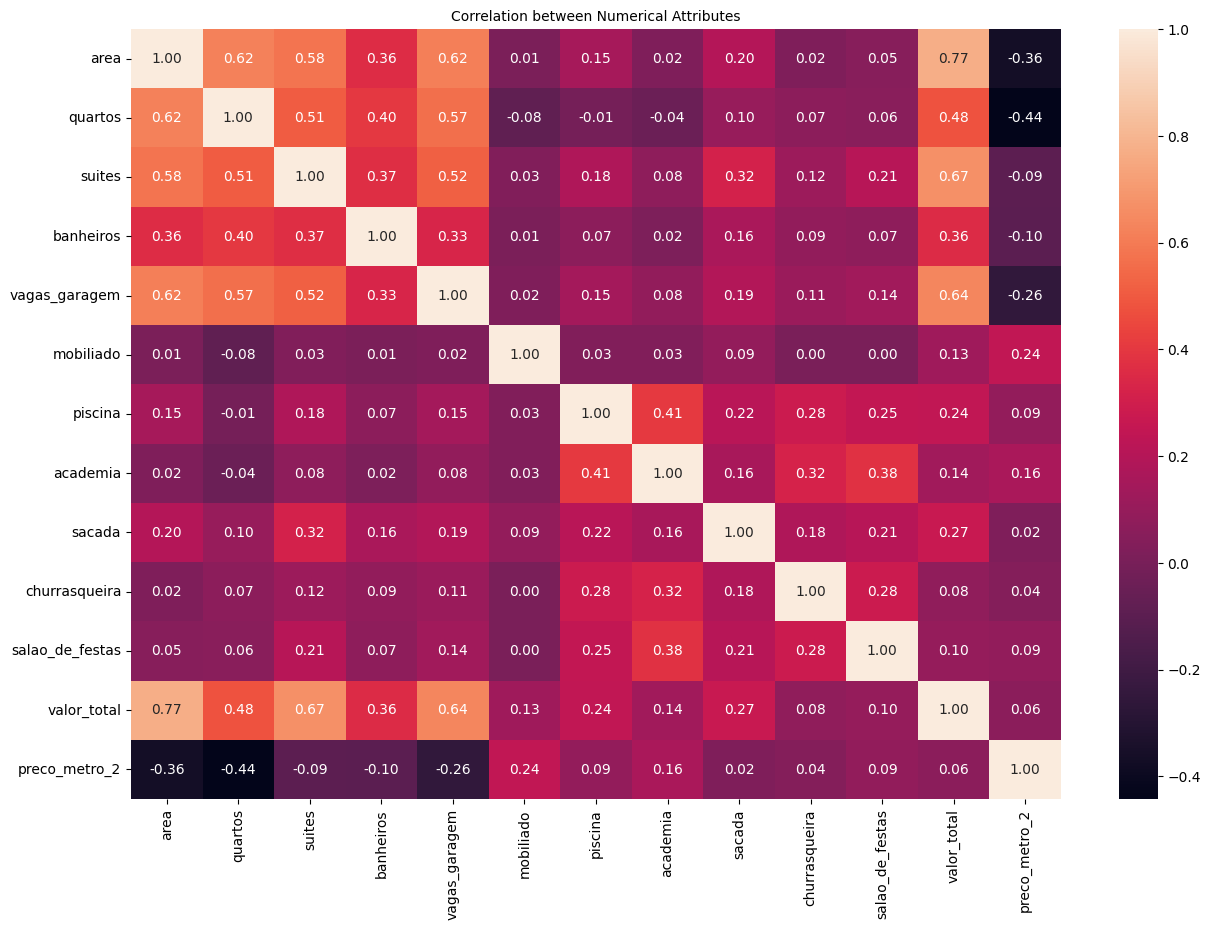

In [51]:
plt.figure(figsize=(15,10))
num_attributes = aux.drop(columns=['aluguel','condominio','seguro_incendio','iptu']).select_dtypes(include=['int64','float64'])
correlations = num_attributes.corr(method='pearson')
plt.title('Correlation between Numerical Attributes',fontsize=10)
sns.heatmap(correlations,annot=True,fmt = '.2f');

In [101]:
# A sacada é o atributo que mais encarece o imóvel
# imóveis com mobilia possuem possue um preço por metro 2 maior
# Imoveis menores possuem um preço por metro 2 maior
# sacada possui uma alta correlação com o valor total mas não com o metro 2

In [120]:
aux = df[['bairro','area', 'preco_metro_2','quartos','suites', 'banheiros', 'vagas_garagem', 'mobiliado', 'piscina','academia', 'sacada', 'churrasqueira', 'salao_de_festas']].copy()

# aux['mobiliado'] = df['mobiliado'].map({'Sim':1,'Não':0})
# aux['piscina'] = df['piscina'].map({'Sim':1,'Não':0})
# aux['academia'] = df['academia'].map({'Sim':1,'Não':0})
# aux['sacada'] = df['sacada'].map({'Sim':1,'Não':0})
# aux['churrasqueira'] = df['churrasqueira'].map({'Sim':1,'Não':0})
# aux['salao_de_festas'] = df['salao_de_festas'].map({'Sim':1,'Não':0})

# aux = pd.get_dummies(aux, columns  = ['bairro'],dtype= float)

In [138]:
contingency

mobiliado,Não,Sim
bairro,,
Agua verde,0.771930,0.228070
Ahu,1.000000,0.000000
Alto boqueirao,1.000000,0.000000
Alto da gloria,0.857143,0.142857
Alto da xv,1.000000,0.000000
...,...,...
Tingui,1.000000,0.000000
Uberaba,1.000000,0.000000
Vila izabel,0.800000,0.200000


<Axes: xlabel='bairro', ylabel='sacada'>

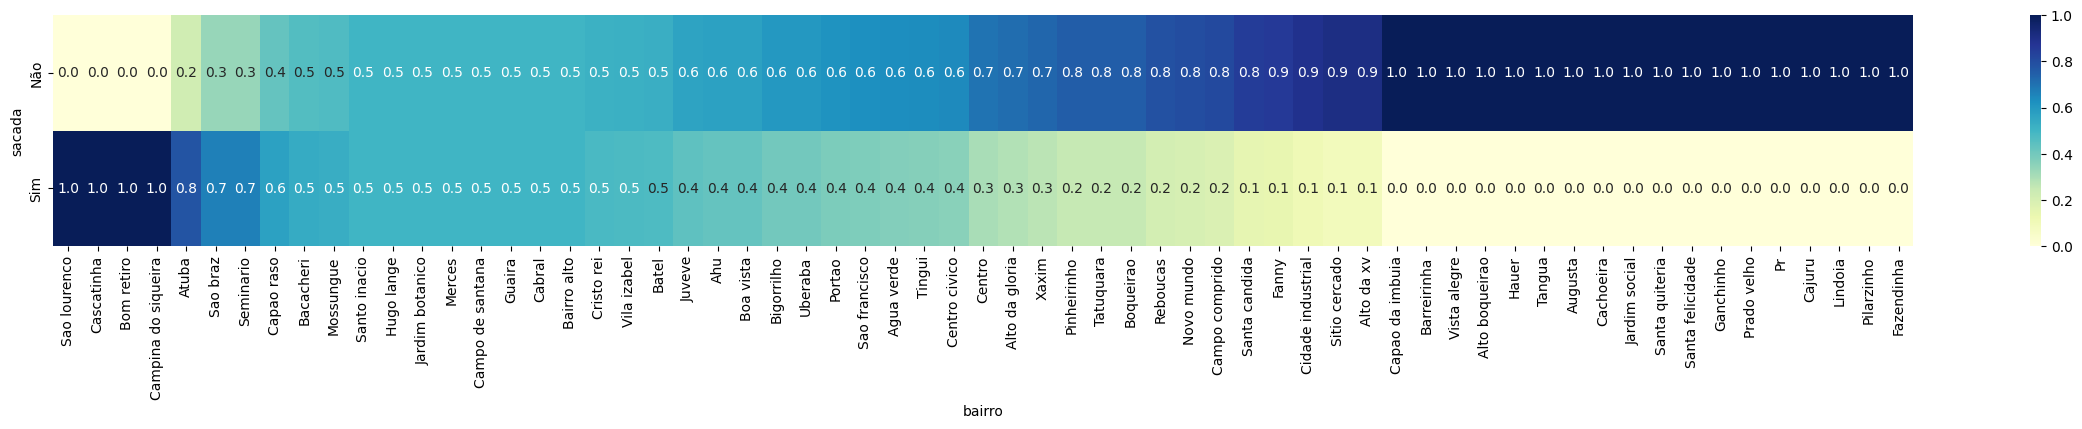

In [146]:
plt.figure(figsize=(30,3))
contingency = pd.crosstab(aux['bairro'],aux['sacada'],normalize='index').sort_values('Sim', ascending=False)
sns.heatmap(contingency.T, annot=True, cmap='YlGnBu',fmt='.1f')

In [145]:
from scipy.stats import chi2_contingency

# Teste qui-quadrado
chi2, p, dof, expected = chi2_contingency(contingency)
print("Valor p:", p)

Valor p: 0.9999999987503561


In [121]:
aux

,bairro,area,preco_metro_2,quartos,suites,banheiros,vagas_garagem,mobiliado,piscina,academia,sacada,churrasqueira,salao_de_festas
0,Mossungue,330.0,36.844303,4,1,1,2,Não,Não,Não,Não,Não,Não
1,Merces,163.0,55.739325,2,1,2,2,Não,Não,Sim,Não,Sim,Não
2,Bigorrilho,103.0,51.988447,3,1,2,2,Não,Não,Sim,Sim,Não,Sim
3,Bigorrilho,118.0,43.446610,3,1,2,1,Não,Não,Sim,Sim,Sim,Sim
4,Portao,90.0,54.324778,2,1,1,1,Sim,Não,Sim,Sim,Sim,Sim
...,...,...,...,...,...,...,...,...,...,...,...,...,...
786,Cachoeira,52.0,23.312500,2,0,1,1,Não,Não,Não,Não,Não,Sim
787,Cristo rei,52.0,26.307500,2,0,1,0,Não,Não,Não,Não,Não,Não
788,Campo comprido,55.0,24.375455,3,0,1,1,Não,Não,Não,Não,Não,Não
789,Centro,48.0,25.691458,1,0,1,0,Não,Não,Não,Não,Não,Não


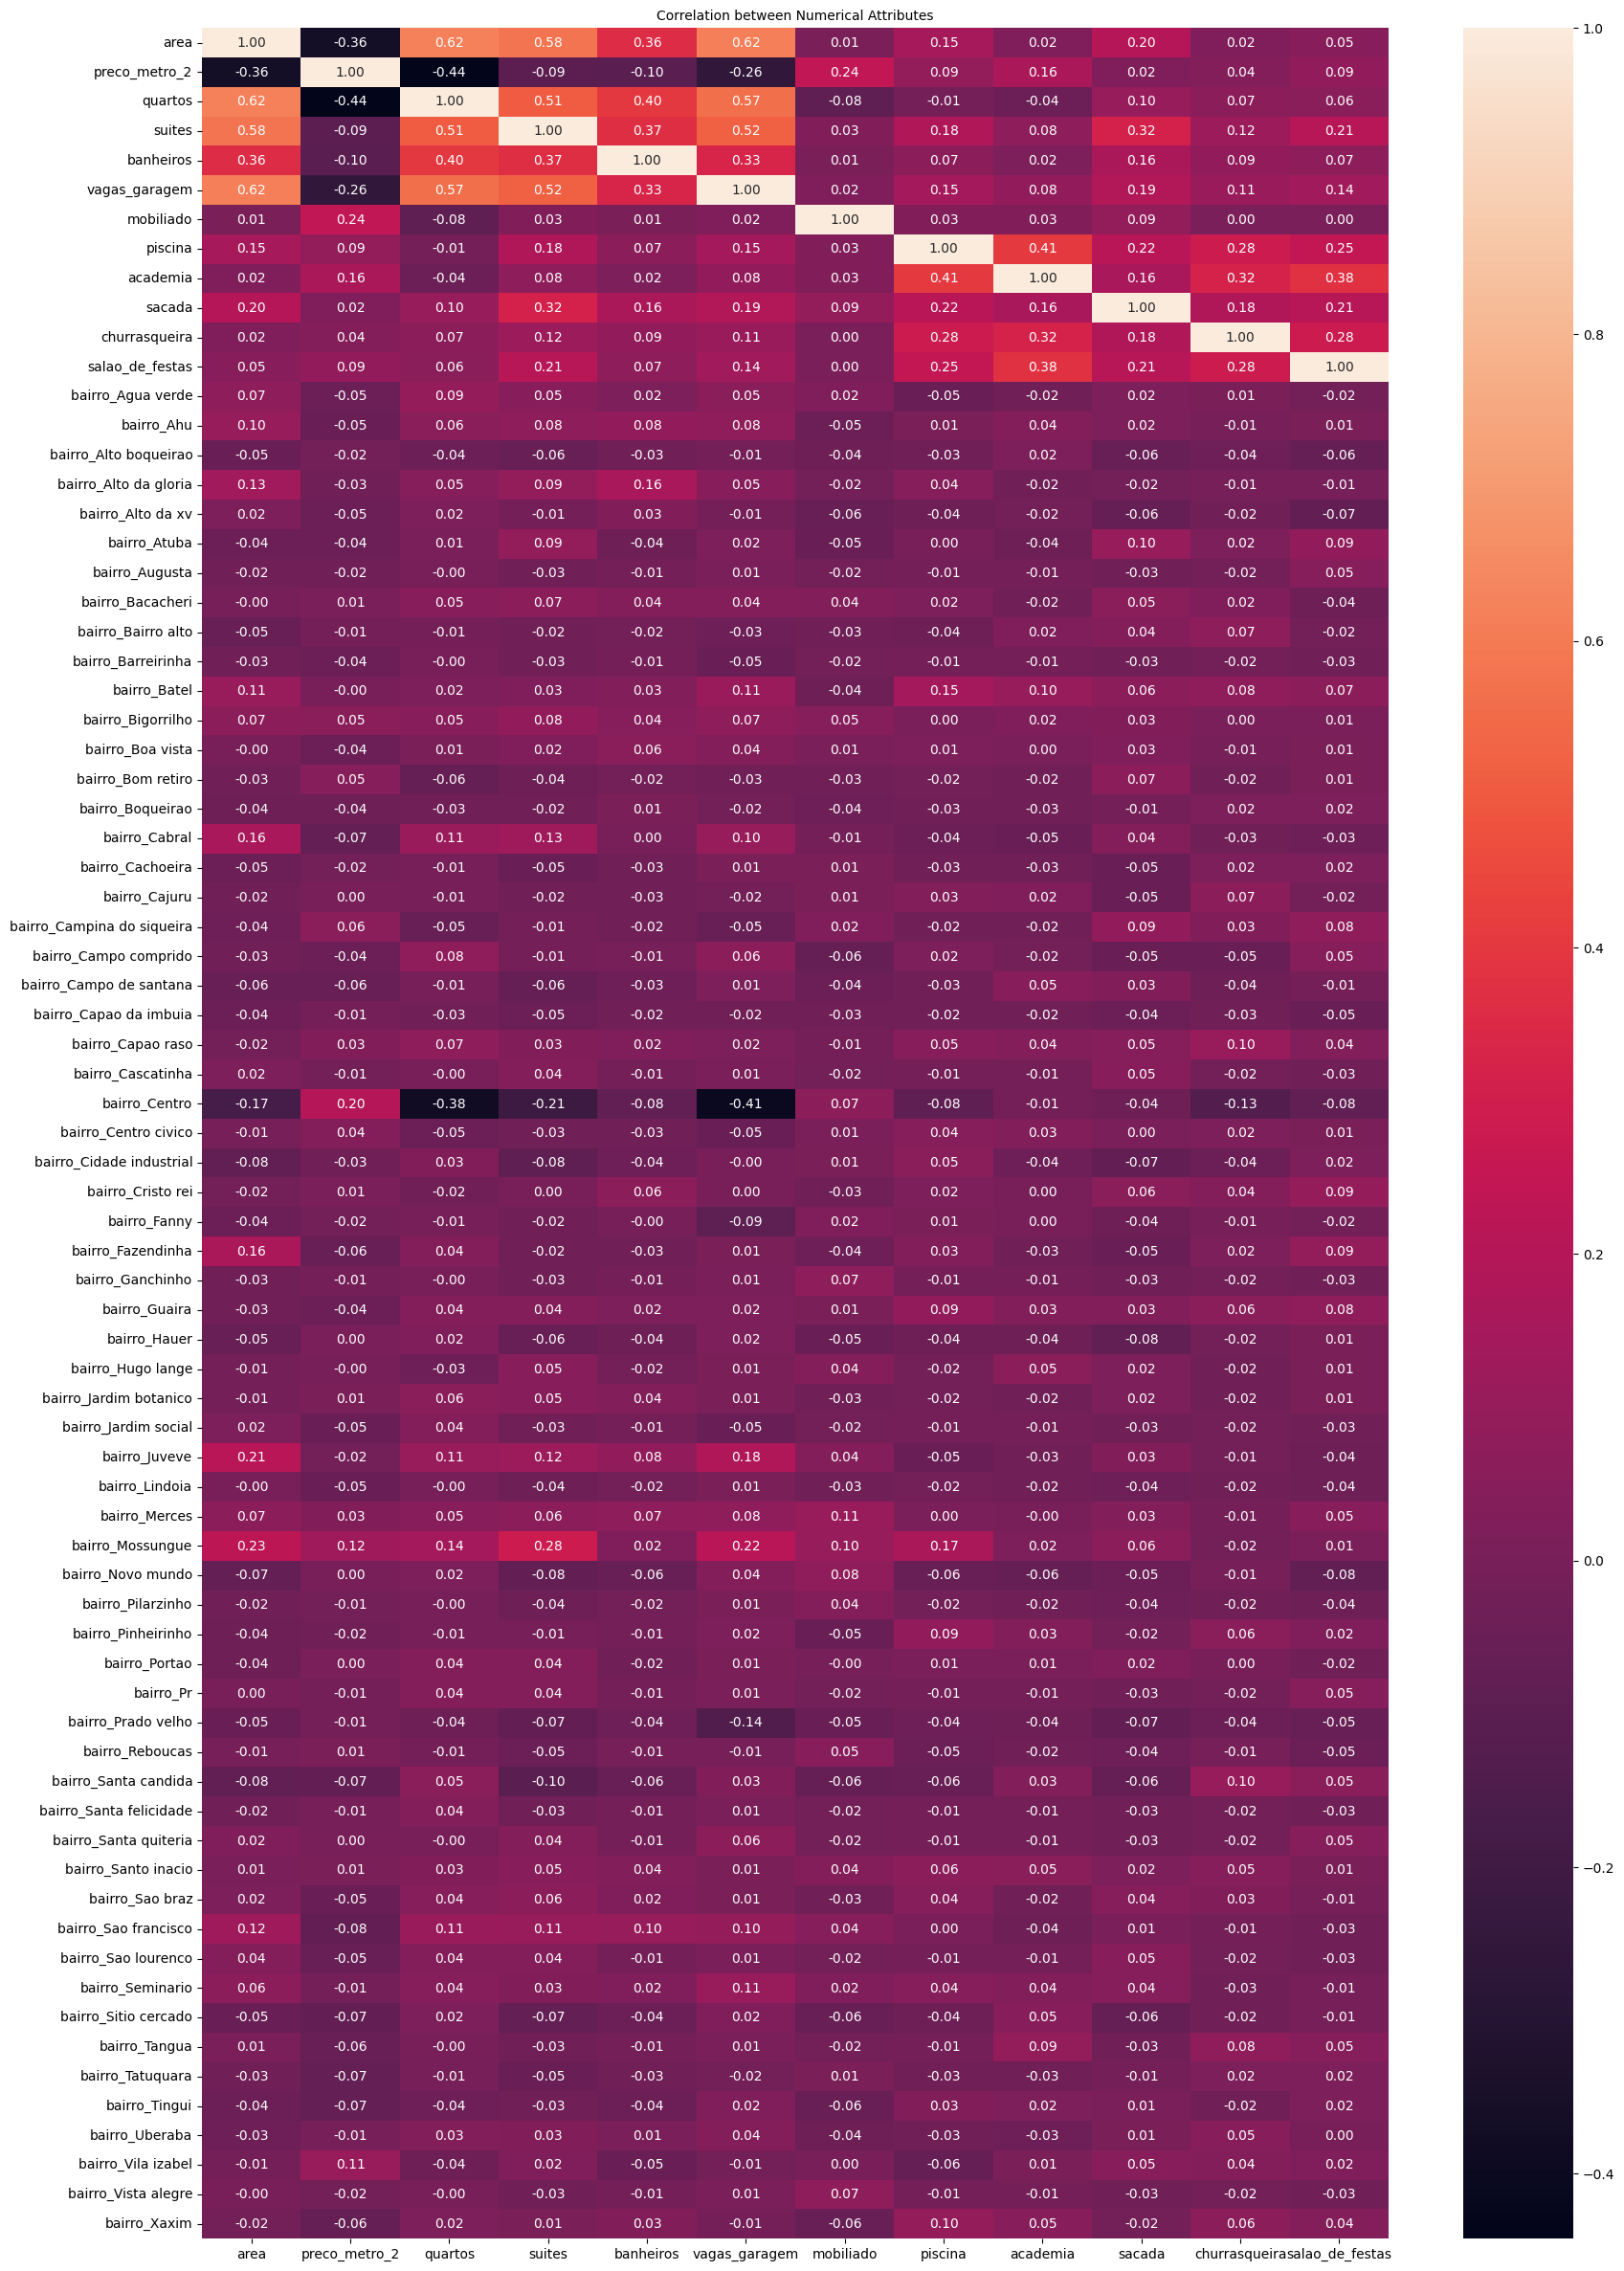

In [116]:
plt.figure(figsize=(20,30))
num_attributes = aux.select_dtypes(include=['int64','float64'])
correlations = num_attributes.corr(method='pearson')
correlations = correlations[['area','preco_metro_2','quartos','suites','banheiros','vagas_garagem','mobiliado','piscina','academia','sacada','churrasqueira','salao_de_festas'	]]
plt.title('Correlation between Numerical Attributes',fontsize=10)
sns.heatmap(correlations,annot=True,fmt = '.2f');